In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PytorchAD import AnomalyDetector
from ADClassifier import ADClassifier
from utils import get_feature_map, load_data
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import time
from itertools import product
import datetime
import matplotlib

# Prepare data

In [2]:
# Load data
mirai = load_data("data/mirai_vector.pkl")
labels = load_data("data/mirai_labels.pkl")

# KitNET params
maxAE = 10 #maximum size for any autoencoder in the ensemble layer
FMgrace = 5000 #the number of instances taken to learn the feature mapping (the ensemble's architecture)
ADgrace = 50000 #the number of instances used to train the anomaly detector (ensemble itself)

# Train FM and initialize AD
v = get_feature_map(mirai.numpy(), FMgrace, maxAE)
AD = AnomalyDetector(v, device="cpu")
#AD.load_state_dict(torch.load("AD_model_state_dict.pt"))
AD = torch.load("model/AD_model.pt")
AD.eval()

AnomalyDetector(
  (ensemble_layer): ModuleList(
    (0): Autoencoder()
    (1): Autoencoder()
    (2): Autoencoder()
    (3): Autoencoder()
    (4): Autoencoder()
    (5): Autoencoder()
    (6): Autoencoder()
    (7): Autoencoder()
    (8): Autoencoder()
    (9): Autoencoder()
    (10): Autoencoder()
    (11): Autoencoder()
    (12): Autoencoder()
    (13): Autoencoder()
    (14): Autoencoder()
    (15): Autoencoder()
    (16): Autoencoder()
    (17): Autoencoder()
  )
  (output_layer): Autoencoder()
)

# Classifier

In [3]:
returnLogit = False
threshold = 1.
ADC = ADClassifier(AD, threshold, logit=returnLogit).cpu().eval()

saveModel = False
if saveModel:
    saveTime = time.strftime("%Y%m%d-%H%M%S")
    torch.save(ADC.state_dict(), "model/ADC_logit{}_model_mirai_state_dict_{}.pt".format(returnLogit, str(saveTime)))
    torch.save(ADC, "model/ADC_logit{}_model_mirai_{}.pt".format(returnLogit, str(saveTime)))

# Benign and malicious samples

In [4]:
def get_rand(mirai, labels, target_label, sample_num):
    sample_idx = np.random.choice(np.where(labels == target_label)[0], sample_num, replace=False)
    mirai_sample = torch.tensor(mirai[sample_idx])
    label_sample = torch.tensor(labels[sample_idx])
    return mirai_sample, label_sample, sample_idx

In [5]:
def get_k_top(mirai, labels, threshold, sample_num):
    # malicious samples with score closed to threshold
    mirai_predM = mirai[AD(torch.tensor(mirai))>threshold]
    labels_predM = labels[AD(torch.tensor(mirai))>threshold]
    _, Msample_idx = torch.topk(AD(torch.tensor(mirai_predM))-threshold, k=sample_num,largest=False)
    mirai_Msample = torch.tensor(mirai_predM[Msample_idx])
    label_Msample = torch.tensor(labels_predM[Msample_idx])
    return mirai_Msample, label_Msample, Msample_idx

In [6]:
sample_num = 10
# random benign samples
mirai_Bsample, label_Bsample, Bsample_idx = get_rand(mirai, labels, 0, sample_num)

# malicious samples with RMSE closed to threshold
# mirai_Msample, label_Msample, Msample_idx = get_k_top(mirai, labels, threshold, sample_num)
mirai_Msample, label_Msample, Msample_idx = get_k_top(mirai, labels, 1, sample_num)


C:\Users\qiuhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\qiuhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
C:\Users\qiuhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
C:\Users\qiuhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarn

# AdverTorchAttack: CW and ElasticNet

In [7]:
from advertorch.attacks import CarliniWagnerL2Attack, ElasticNetL1Attack

In [8]:
def Dist(orig, adv, printInfo=False):
    '''
    print L0, L1, L2 and L_inf distance.
    '''
    dif = orig - adv
    res = []
    p_list = [0., 1., 2., float('inf')]
    for p in p_list:
        dist = torch.norm(dif, p, 1)
        res.append(torch.mean(dist))
        if printInfo:
            print("L_{} distance: {:.2f}±{:.2f},".format(p, torch.mean(dist), torch.std(dist)), end=" ")
    print()
    return res

In [9]:
def attack_test(attack, mirai_sample, label_sample):
    '''
    auxillary function for test attack algorithms.
    '''
    adv = attack.perturb(mirai_sample, label_sample.reshape(-1).long())
    original_res = torch.argmax(ADC(mirai_sample),dim=1)
    adv_res = torch.argmax(ADC(adv),dim=1)
    
    print("Original: ", original_res)
    print("Adversarial: ", adv_res)
    print("Success rate: ", len(torch.where((original_res != adv_res))[0])/len(adv_res))
    print("Distance:")
    Dist(adv, mirai_sample, True)
    return adv

CW_L2

In [10]:
cw_attack = False
if cw_attack:
    adv_FP_cw = attack_test(CarliniWagnerL2Attack(ADC, num_classes=2, clip_min=mirai_Bsample.min(), clip_max=mirai_Bsample.max()),
                        mirai_Bsample,
                        label_Bsample)

    adv_FN_cw = attack_test(CarliniWagnerL2Attack(ADC, num_classes=2, clip_min=mirai_Msample.min(), clip_max=mirai_Msample.max()),
                        mirai_Msample,
                        label_Msample)

    adv_FN2_cw = attack_test(CarliniWagnerL2Attack(ADC, num_classes=2, clip_min=mirai_Msample2.min(), clip_max=mirai_Msample2.max()),
                        mirai_Msample2,
                        label_Msample2)

Elastic L1

In [11]:
en_attack = False
if en_attack:
    # other attack option: decision_rule='EN'
    adv_FP_en = attack_test(ElasticNetL1Attack(ADC, num_classes=2, clip_min=mirai_Bsample.min().item(), clip_max=mirai_Bsample.max().item()),
                        mirai_Bsample,
                        label_Bsample)

    gridsearch = False
    if gridsearch:
        initial_const_list = [1, 10, 100, 200, 500]
        beta_list = [1e-2, 1e-1, 1]
        binary_seach_list = [9, 20]
        dict_adv = {}
        for prod in product(initial_const_list, beta_list, binary_seach_list):
            adv_FN = attack_test(ElasticNetL1Attack(ADC, num_classes=2, clip_min=mirai_Msample.min().item(), clip_max=mirai_Msample.max().item(),
                                               initial_const=prod[0],
                                                   beta=prod[1],
                                                   binary_search_steps=prod[2]),
                            mirai_Msample,
                            label_Msample)
            dict_adv[prod]=adv_FN
            print("Finished ", prod)

# Select threshold

In [12]:
print("Number of instances: ", len(mirai))
error_pred = AD(torch.tensor(mirai[55001:])).detach().numpy()
print("Maximum of test error: ", error_pred.max())

th_list = [0.0, 0.01, 0.03, 0.05, 0.1,0.25, 1.0, 5.0, 7.0, 10.0, 15.0, 20.0]
rates_of_false_positive = []
rates_of_false_negative = []
accuracy_list = []
benign_samples = np.where(labels[55001:] == 0)[0]
mal_samples = np.where(labels[55001:] == 1)[0]
for th in th_list:
    pred = (error_pred>th).astype(np.long)
    accuracy_list.append(accuracy_score(pred, labels[55001:])*100)
    rates_of_false_positive.append(len(np.where(pred[benign_samples]==1)[0])/len(benign_samples)*100)
    rates_of_false_negative.append(len(np.where(pred[mal_samples]==0)[0])/len(mal_samples)*100)

Number of instances:  764137


C:\Users\qiuhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Maximum of test error:  159021859194.0772


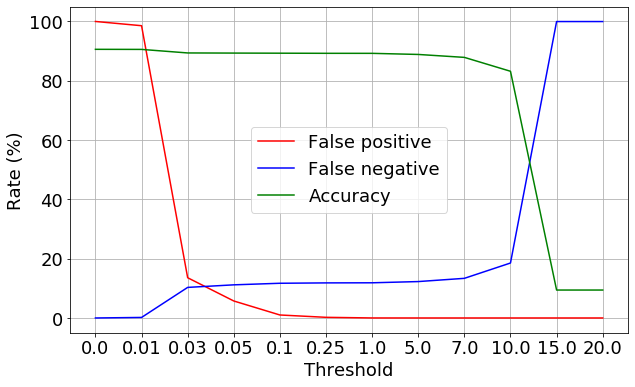

In [13]:
# generate axis label
th_str = []
for th in th_list:
    th_str.append(str(th))
font_size = 18
font = {'size':font_size}
matplotlib.rc('font', **font)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot()
ax.plot(range(len(th_list)), rates_of_false_positive, color='r', label="False positive")
ax.plot(range(len(th_list)), rates_of_false_negative, color='b', label="False negative")
ax.plot(range(len(th_list)), accuracy_list, color='g', label="Accuracy")
ax.set_xlabel("Threshold", fontsize=font_size)
ax.set_ylabel("Rate (%)", fontsize=font_size)
ax.set_xticks(range(len(th_list)))
ax.set_xticklabels(labels = th_list, fontsize=font_size)
ax.legend(prop={'size': font_size})
ax.grid(True)
# plt.savefig("result/threshold_select.png", dpi=1200)
plt.savefig("result/threshold_select.pdf")
plt.show()

# Saliency map

In [14]:
def saliency_map_onevec(f, X, t):
    '''
    Compute saliency map given f function, X input and t target class.
    Attention: X must be a vector of shape (1, x) where x is the length of X
    '''
    X.requires_grad_(True)
    target_proba = f(X)[0,t]
    target_proba.backward()
    return F.relu(X.grad)

In [15]:
font_size = 18
def saliency_map(f, X, t, plotres=False, limit_num=100, xticks=None, ytick=None, plotsavePath=None, fs=font_size+16):
    '''
    Compute saliency map given f function, X input and t target class.
    '''
    Smap = torch.zeros_like(X)
    for i, x in enumerate(X):
        Smap[i] = saliency_map_onevec(f, x.reshape(1,-1), t)
    if plotres:
        font = {'size':fs}
        matplotlib.rc('font', **font)
        fig = plt.figure(figsize=(36,6))
        ax = fig.add_subplot()
        res = Smap[:limit_num].numpy()
        
        s = ax.imshow(res, aspect='auto')
        #plt.xticks(np.arange(Smap.shape[1]/10), fontsize=fs-3)
        ax.set_xlabel("Index")
        if xticks is None:
            xticks = np.array([0,15,50,65,99])
        
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(labels=xticks)#, fontsize=fs)
        if ytick is not None:
            ax.set_ylabel("RMSE")#, fontsize=fs)
            
            ax.set_yticks(ticks=range(Smap[:limit_num].shape[0]))
            ax.set_yticklabels(labels=ytick)#, fontsize=fs)
            
        #plt.colorbar()
        cb = fig.colorbar(s, ax=ax)
        #cb.ax.tick_params(labelsize=fs)
        plt.tight_layout()
        if plotsavePath is not None:
            plt.savefig(plotsavePath, bbox_inche='tight', dpi=800)
        plt.show()
    return Smap

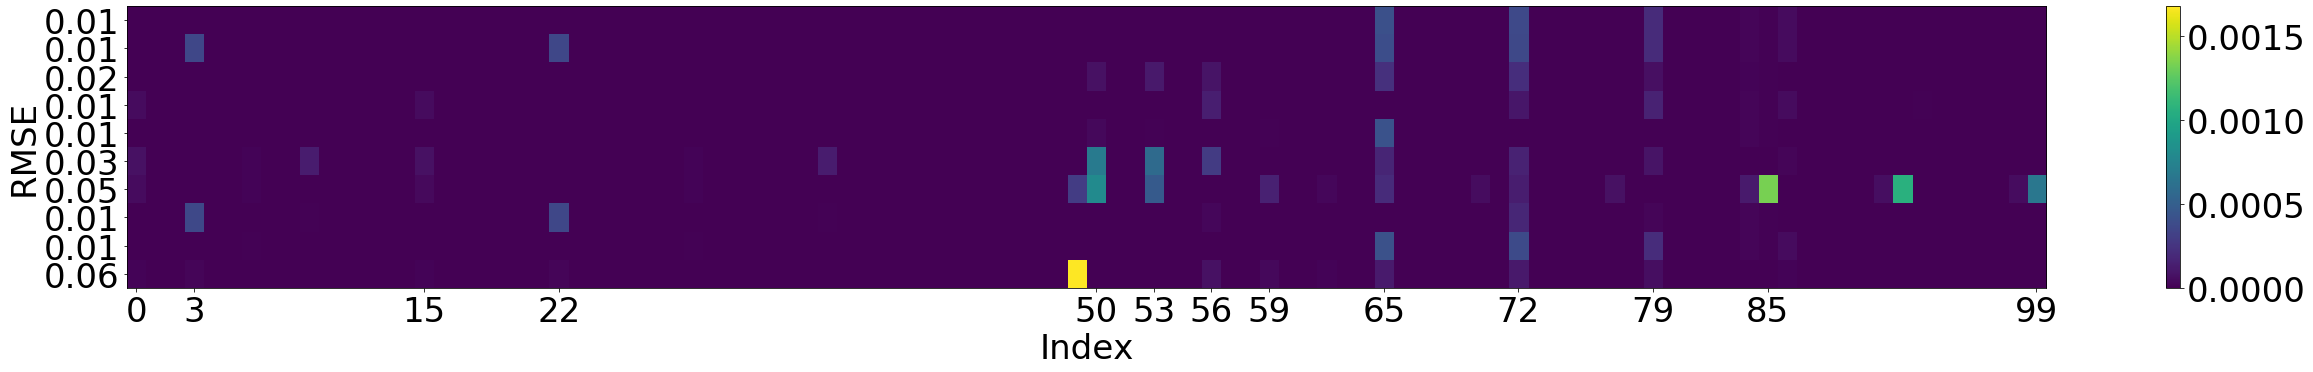

In [16]:
#filename = "result/saliency_map_benign_"+str(datetime.datetime.now()).replace(" ", "").replace(":", "").split(".")[0]+".png"
filename = "result/saliency_map_benign.pdf"
Smap_Benign = saliency_map(ADC, mirai_Bsample, 1, 
                           plotres=True, 
                           xticks=np.array([0,3,15,22,50,53,56,59,65,72,79,85,99]),
                           ytick=np.round(AD(mirai_Bsample).detach().numpy(), 2),
                          plotsavePath=filename)

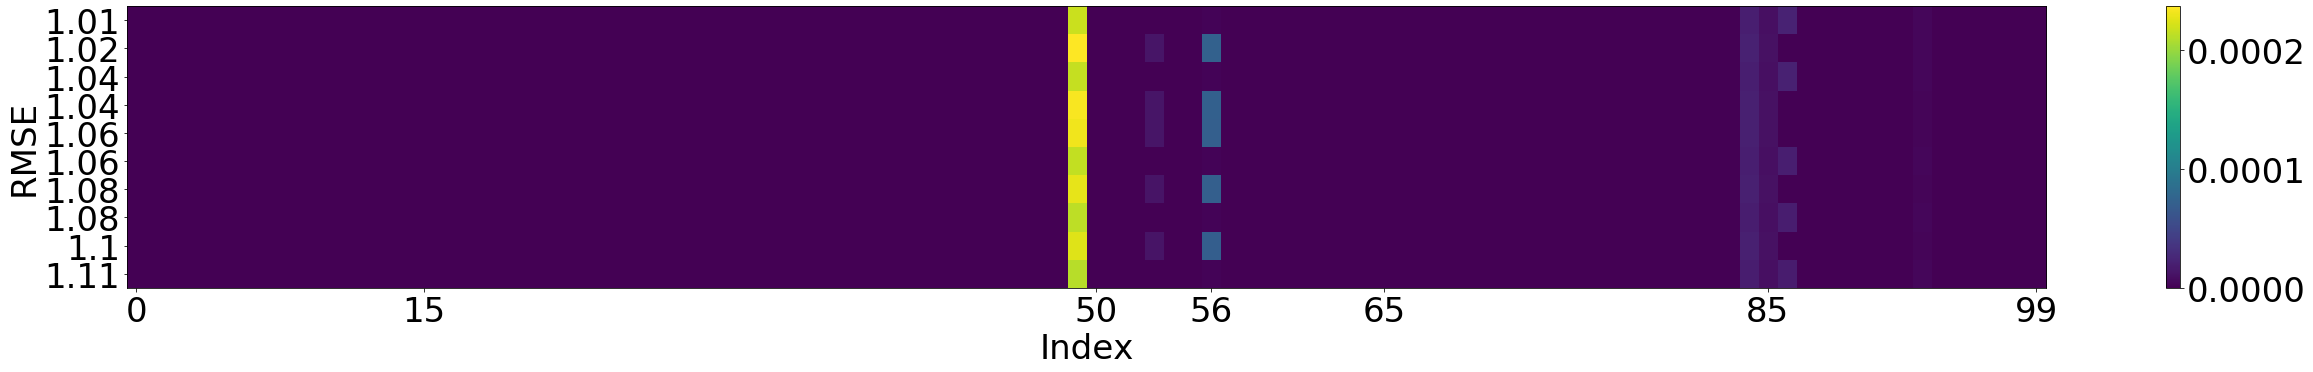

In [17]:
#filename = "result/saliency_map_malicious_"+str(datetime.datetime.now()).replace(" ", "").replace(":", "").split(".")[0]+".pdf"
filename = "result/saliency_map_malicious.pdf"
Smap_Malicious = saliency_map(ADC, mirai_Msample, 0, 
                           plotres=True, 
                            xticks=np.array([0,15,50,56,65,85,99]),
                           ytick=np.round(AD(mirai_Msample).detach().numpy(), 2),
                          plotsavePath=filename)